<div align="center"> <h1> ISYE_6740_20su_team308 </h1></div>


<div align="center"> <h2> Final Project </h1></div>

****

<h4>By: Jonathan Chen (GTid: 902912657)  </h4>
<h4>Project Title: The Weight of Profanity on Film</h4>

<h3> Problem Statement </h3>

The Pareto principle states roughly that 80% of the effects come from 20% of the causes. This principle, while originally observed by Vilfredo Pareto in relation to population and wealth dynamics in late 19th century Italy has however found application in other fields. Corporate motivational speakers now make it a point to emphasize leveraging the top-most portion of their assets to see more efficient growth. Programmers have noted that most bugs and errors derive from a few lines of faulty code in production. And dating pessimists will personally regale you with anecdotes of how a vast majority of their dates have been wide misses, despite eHarmony's promises otherwise. And while the 80 to 20 proportion may fluctuate from case to case and field to field, the idea that a majority of the effects can come from a minority of causes now pervades the modern era. 

In this report I would like to explore the Pareto Principle roughly applied to the effect of profanity on film. To gain proper intuition please watch the following clip from acclaimed and revered, American culture staple - ['Spongebob Squarepants'.](https://www.youtube.com/watch?v=bifmGtO56-Y) According to Patrick, some select (swear) words can be utilized and thought of as "sentence enhancers" which despite being utilized sparingly, can greatly magnify the effect of whatever is being said.  

To a certain degree, America's film rating system is based on the amount of sentence enhancers that appear in a film. But there does not seem to be a hardline threshold of profanity for different ratings however. This is one of the relationships I plan to explore regarding films and the profanity that they contain. Specifically, I aim to create a model to rate a film based on the swears it contains (both type and frequency). And also see if this relationship changes based on the genre of the film. Recall - Patrick's assertion that profanity can be used to enhance a sentence, in the scope of film - this could mean enhancing the delivery of lines, which may mean more moving scenes, higher critic scores, and ticket sales. As such, I'll also be exploring the effect of profanity on critical reception and domestic gross. 

<h3> Data Sourcing and Preparation </h3>

The focal point of this project is the profanity contained in each film. There was unfortunately no prior data source containing this data. I did however have access to an [online database of film scripts](https://www.imsdb.com/). For each movie, after navigating to the script page, I would then use regex patterns to count the occurrences of each type of cuss. The reason why I used regex specifically, was because I wanted to be able to capture different forms of each swear.   

For example: 

1) For the F-word - I wanted to catch alterations, such as 'f-er', 'f-ng' and 'motherf-er' which I can capture with r"[Ff]uck".  

2) For the A-word  - I wanted different form like before, such as 'a-hole', but I also didn't want to falsely identify regular words such as 'pass' or 'lass'. So I used this regex pattern  = r"(\b|[Dd]umb)[Aa]ss(\b|h)". Which would exclude words like 'passport' and 'gassed', but would recognize 'dumba-' which I would count as a permutation of 'a-'
  
To gather this data efficiently, I created a web crawler to extract this data along with the genre that the website had already classified each movie as. This web crawler yeilded me a set of 1.1k Films, matched with their genre, and count of F-words, D-words, B-words, and A-words.  

This data by itself only offers the ability to model profanity against genre. However, I still need to get atleast box office and critical reception data. I decided to do this by using [the OMDb API](http://www.omdbapi.com/). This API allowed me the possibility of getting the rest of my desired metrics but was unfortunately inconsistent in application. Not every field that had a non-null value, and when using movie names for querying as opposed to IMDb ID (which was not available in the original data set) the API would return null for some variations E.g. 'Hateful 8' vs. 'Hateful Eight'. 

So to get my final dataset as complete as possible I would loop through the original list of screenplays and make a list of those that failed to pull from the API correctly. And then I would change my strategy (getting rid of punctuation, changing numbers into words, words into numbers, numbers into roman numerals, and foreign titles into English) and try to get as many matches as possible. 

In the end I'd have a table filled with rows like this:

| Film | Genre | Year | Rated | Released | Runtime | Metascore | imdbRating | imdbVotes | imdbID | BoxOffice | A | B | D | F | S |
|------|-------|------|-------|----------|---------|-----------|------------|-----------|--------|-----------|---|---|---|---|---|
| 12 Monkeys       | Sci-Fi | 1995 | R | 1/5/1996  | 129 | 74 | 8   | 565400 | tt0114746 |          | 6 | 3 | 4  | 8 | 5 |
| 12 Years a Slave | Drama  | 2013 | R | 11/8/2013 | 134 | 96 | 8.1 | 617390 | tt2024544 | 50628650 | 0 | 1 | 25 | 1 | 0 |

<h3> Methodology</h3>

There are a couple columns that still need to be processed before they can be useful for regression and classification.

This first features that need to be looked at are the columns counting the profanity words themselves, A,B,D,F, and S. These columns are a bit biased in that, they are raw counts and therefore may be biased towards higher counts on longer movies. So to offer an alternative measure while still capturing the prevalence of each cuss, I created five mirroring measures by dividing the counts by the 'Runtime' measured in minutes. In the specific case of transforming 'F' which is counts of the pattern [Ff]uck, to FPM, which would be [Ff]uck's per minute. The other new columns follow a similar intuition, B becomes counts to BPM ([Bb]itch's per minute) and so on. 

'Genre' is a  categorical variable. To have it properly function in either a tree or regression function, I used pandas.get_dummies function to create binary columns that represent membership. The same methodology can be applied to 'Rated', so long as it's not the response I'm trying to predict. 

Unfortunately, the API doesn't match every film name completely correctly even on successful requests and sometimes returned back records that were no whhere close to the screenplays. For example, the 2014 dark comedy movie "Birdman" was confused by the API for the 1967 TV animated show Birdman and the Galaxy Trio, creating a record that matched a profanity rich screenplay to a short runtime and kid's rating. This mismatching meant there were TV-rating values that came attached to movies that spawned from related TV shows (though not in the exact case of Birdman). To best generalize in these cases, I lumped in each TV rating with their corresponding movie rating (e.g. PG and TV-PG) and counted NC-17 movies with the R rating. 

When planning for critical reception, I realized that I had two critic scores to work with, but on account on the inconsistency of the 'Metascore' column, when solving for critic score I decided to take the greater of the 'Metascore/10' and 'imdbRating', or whichever record was non-null. 

In general, I'll be dropping the rows that have N/A to combat the inconsistencies in the API columns so I'll have full records for regression and building trees. I'll also be splitting the remaining full records into training and test sets. 

<h3>Evaluation and Results</h3>

<h5>Profanity's effect on Film Rating</h5>

When considering the features available that might influence a film's rating, only the profanity measure (both count and per minute) and its genre seem to be appropriate. Everything else is either irrelevant (such as title), or an after-the-fact metric (such as critic score, release date, or box office value).  

To get a better a sense of the overall relationship of genre and rating, I first plotted its breakdown. 

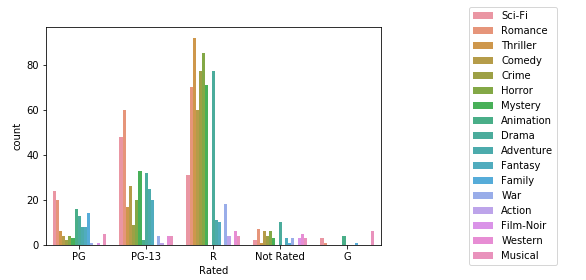

Which shows a very large makeup of R-rated movies. With almost half the movies in the list being rated R, our model should ideally have a higher accuracy than 50% otherwise, we'd be just as good having a Naive Classifier only returning "R" labels. 

As a starting point for multi-label classification, I chose to use a Naive Bayesian model. With the 'Rated' column as my response, I cycled through different iterations of using count and per-minute measures alongside the variables 'Year' and 'Genre', which as covered from before had been turned into multiple binary dummy columns. The results are as follows: 

| Features                                       | Accuracy  |
|------------------------------------------------|-----------|
| ['A','B','D','F','S']                          | 40%       |
| ['APM','BPM','DPM','FPM','SPM']                | 39%       |
| ['Year','A','B','D','F','S']                   | 47.5%     |
| ['Year','APM','BPM','DPM','FPM','SPM']         | 46%       |
| ['APM','BPM','DPM','FPM','SPM','Genre']        | 26%       |
| ['A','B','D','F','S','Genre']                  | 37.7%     |
| ['APM','BPM','DPM','FPM','SPM','Genre','Year'] | 34.6%     |
| ['A','B','D','F','S','Genre','Year']           | 41.7%     |

This initial run was more to highlight the abysmal accuracy than it was a serious attempt. The primary assumption of a Naive Bayes model is that the predictors are independent. Which at the very least, 'Genre' and swear word usage are. So while the third option had to the highest accuracy on the test set, it is certainly not high or distinctive enough to truly delve deeper into in thought.

The next approach I took was to use the KNN classifier, with the same set of feature combinations as before. The only difference being, that now that I had to also consider the parameter 'K' number of neighbors. To pick the optimal 'K' I tried a range of K=2 through 30 for each and recorded highest accuracies. My results from that are as follows:

| Features                                       | Accuracy |
|------------------------------------------------|----------|
| ['A','B','D','F','S']                          | 66.0%    |
| ['APM','BPM','DPM','FPM','SPM']                | 65.0%    |
| ['Year','A','B','D','F','S']                   | 72.0%    |
| ['Year','APM','BPM','DPM','FPM','SPM']         | 63.0%    |
| ['APM','BPM','DPM','FPM','SPM','Genre']        | 65.7%    |
| ['A','B','D','F','S','Genre']                  | 65.7%    |
| ['APM','BPM','DPM','FPM','SPM','Genre','Year'] | 64.8%    |
| ['A','B','D','F','S','Genre','Year']           | 72.0%    |

The accuracies were significantly better than in the Naive Bayes run, with the third option (again) and the last option having the highest accuracies. Here is the 3rd option's accuracies plotted agains the number of neighbors. 

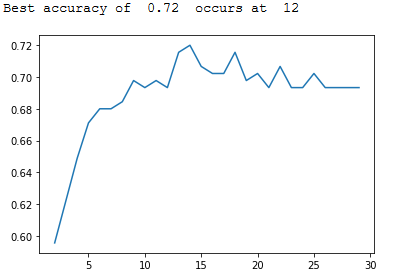

One reason perhaps why KNN worked so much better than Naive Bayes (other than the fact that the underlying assumption for Naive Bayes was not met), is that ~~successful~~ movies will always have its close clones. *Shark Tale* and *Finding Nemo* were both family targeted (so no cussing unfortunately) animated movies about talking fish released just 8 months apart. *No Strings Attached* and *Friends with Benefits* were both rated-R romantic comedies about their titular subjects, released just 6 months apart in 2011 marketed towards anyone bored enough to watch an Ashton-Kutcher-type make googly eyes at a Natalie-Portman-type for 110 minutes. The list goes on and on. These movies, being so similar in genre, time period (to catch the cinematic demand wave) and possibly dialogue (and hence swearing) inadvertently become very close "neighbors" which KNN then use to help classify other movies that are similar. 


I then tried classification trees. Which I hypothesized would be the most distinctive in telling me what potential thresholds were between each of the movie ratings. In my mind I expected a distinct branching of genres and swear threasholds, and I also expected this method to do the best. With a minimum splittable sample node set at 10% of the total sample size to prevent over-branching, this was the result I got:

| Features                                       | Accuracy |
|------------------------------------------------|----------|
| ['A','B','D','F','S']                          | 65.3%    |
| ['APM','BPM','DPM','FPM','SPM']                | 64.0%    |
| ['Year','A','B','D','F','S']                   | 66.7%    |
| ['Year','APM','BPM','DPM','FPM','SPM']         | 68.8%    |
| ['APM','BPM','DPM','FPM','SPM','Genre']        | 61.7%    |
| ['A','B','D','F','S','Genre']                  | 62.7%    |
| ['APM','BPM','DPM','FPM','SPM','Genre','Year'] | 66.2%    |
| ['A','B','D','F','S','Genre','Year']           | 67.0%    |

The performance was not as good as KNN (however slight). And the resulting tree from the 4th feature set gave us:

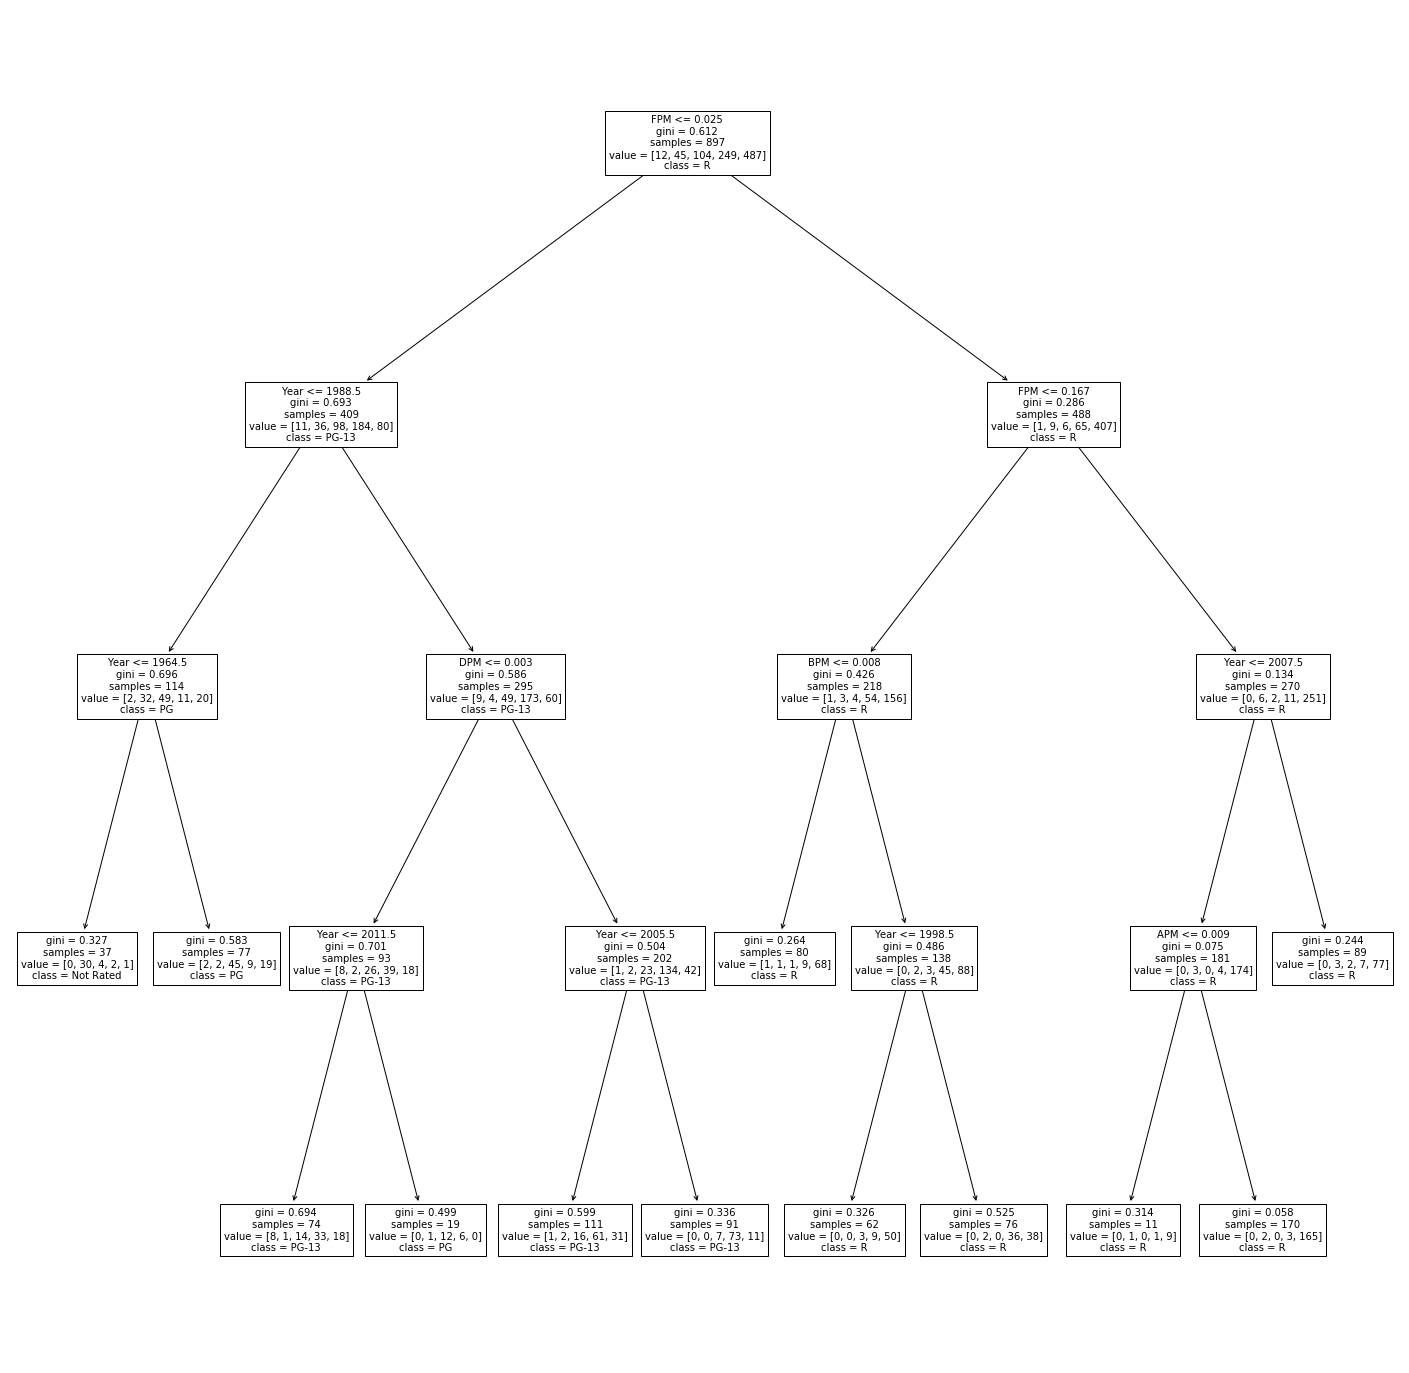

The tree itself wasn't built non-sensically. A couple things caught my eye. The first was that the line between R and PG-13 seemed almost too definite. According to the tree, if there were more than 0.025 [Ff]ucks per minute, the movie would be undoubtably be rated R, regardless of any other factor. This is the very first split, and seemed too hard of a seperator. The other thing that caught my eye was the presence of the left-most node for the "Not Rated" movies, which branched from and located right next to a 'PG' node. 

This did not sit completely right with me, as according to the tree, the main two requirements for an "Not Rated" classification was that it have less than 0.025 [Ff]ucks per minute and be released prior to 1964. These two criteria, while maybe generally accurate for this label, would be completely off for a film like *Beasts of No Nation*, which by all accounts should be rated 'R', but IMDB labels it as "Not Rated". Movies like this, are a far cry from "PG" or even "PG-13". 

This was when I decided to retrace my steps a bit and realized that "Not Rated" movies were extremely variable. Because I had lumped into this category movies that existed before the rating system was fully implemented, "Not Rated" could mean that it had a ton of swears, or it could mean that it was a kids film from the 1930's that just simply didn't have a rating because back the only two distinctions were "Approved" and "Unapproved" (both of which were also lumped into "Not Rated". The original intent was to lump these movies together, to help with generalization. However the resulting huge variance in the these "Not Rated" movies meant that this particular model (and most likely also the previous models) were overfitting to compensate. This overcompensation might also be the reason why in every model far, the best features to use were sets without 'Genre'.


So I decided to repeat the process but this time without the "Not Rated" movies. And because this is only a change to Genre, most of any difference should be in those where the features included 'Genre'. 

The Naive Bayesian model now gave us: 

| Features                                       | Accuracy |
|------------------------------------------------|----------|
| ['A','B','D','F','S']                          | 40.0%    |
| ['APM','BPM','DPM','FPM','SPM']                | 39.0%    |
| ['Year','A','B','D','F','S']                   | 47.5%    |
| ['Year','APM','BPM','DPM','FPM','SPM']         | 46.0%    |
| ['APM','BPM','DPM','FPM','SPM','Genre']        | 60.0%    |
| ['A','B','D','F','S','Genre']                  | 61.0%    |
| ['APM','BPM','DPM','FPM','SPM','Genre','Year'] | 62.0%    |
| ['A','B','D','F','S','Genre','Year']           | 63.0%    |

All of the models that included 'Genre' seeing an increase in accuracy. 

KNN now giving us: 

| Features                                       | Accuracy |
|------------------------------------------------|----------|
| ['A','B','D','F','S']                          | 66.0%    |
| ['APM','BPM','DPM','FPM','SPM']                | 65.0%    |
| ['Year','A','B','D','F','S']                   | 72.0%    |
| ['Year','APM','BPM','DPM','FPM','SPM']         | 63.0%    |
| ['APM','BPM','DPM','FPM','SPM','Genre']        | 73.7%    |
| ['A','B','D','F','S','Genre']                  | 69.9%    |
| ['APM','BPM','DPM','FPM','SPM','Genre','Year'] | 65.0%    |
| ['A','B','D','F','S','Genre','Year']           | 72.7%    |

And finally the decision trees giving us:

| Features                                       | Accuracy |
|------------------------------------------------|----------|
| ['A','B','D','F','S']                          | 67.6%    |
| ['APM','BPM','DPM','FPM','SPM']                | 66.6%    |
| ['Year','A','B','D','F','S']                   | 71.8%    |
| ['Year','APM','BPM','DPM','FPM','SPM']         | 70.9%    |
| ['APM','BPM','DPM','FPM','SPM','Genre']        | 71.4%    |
| ['A','B','D','F','S','Genre']                  | 69.0%    |
| ['APM','BPM','DPM','FPM','SPM','Genre','Year'] | 75.1%    |
| ['A','B','D','F','S','Genre','Year']           | 75.6%    |

With a tree structure looking like this for the last feature set. 

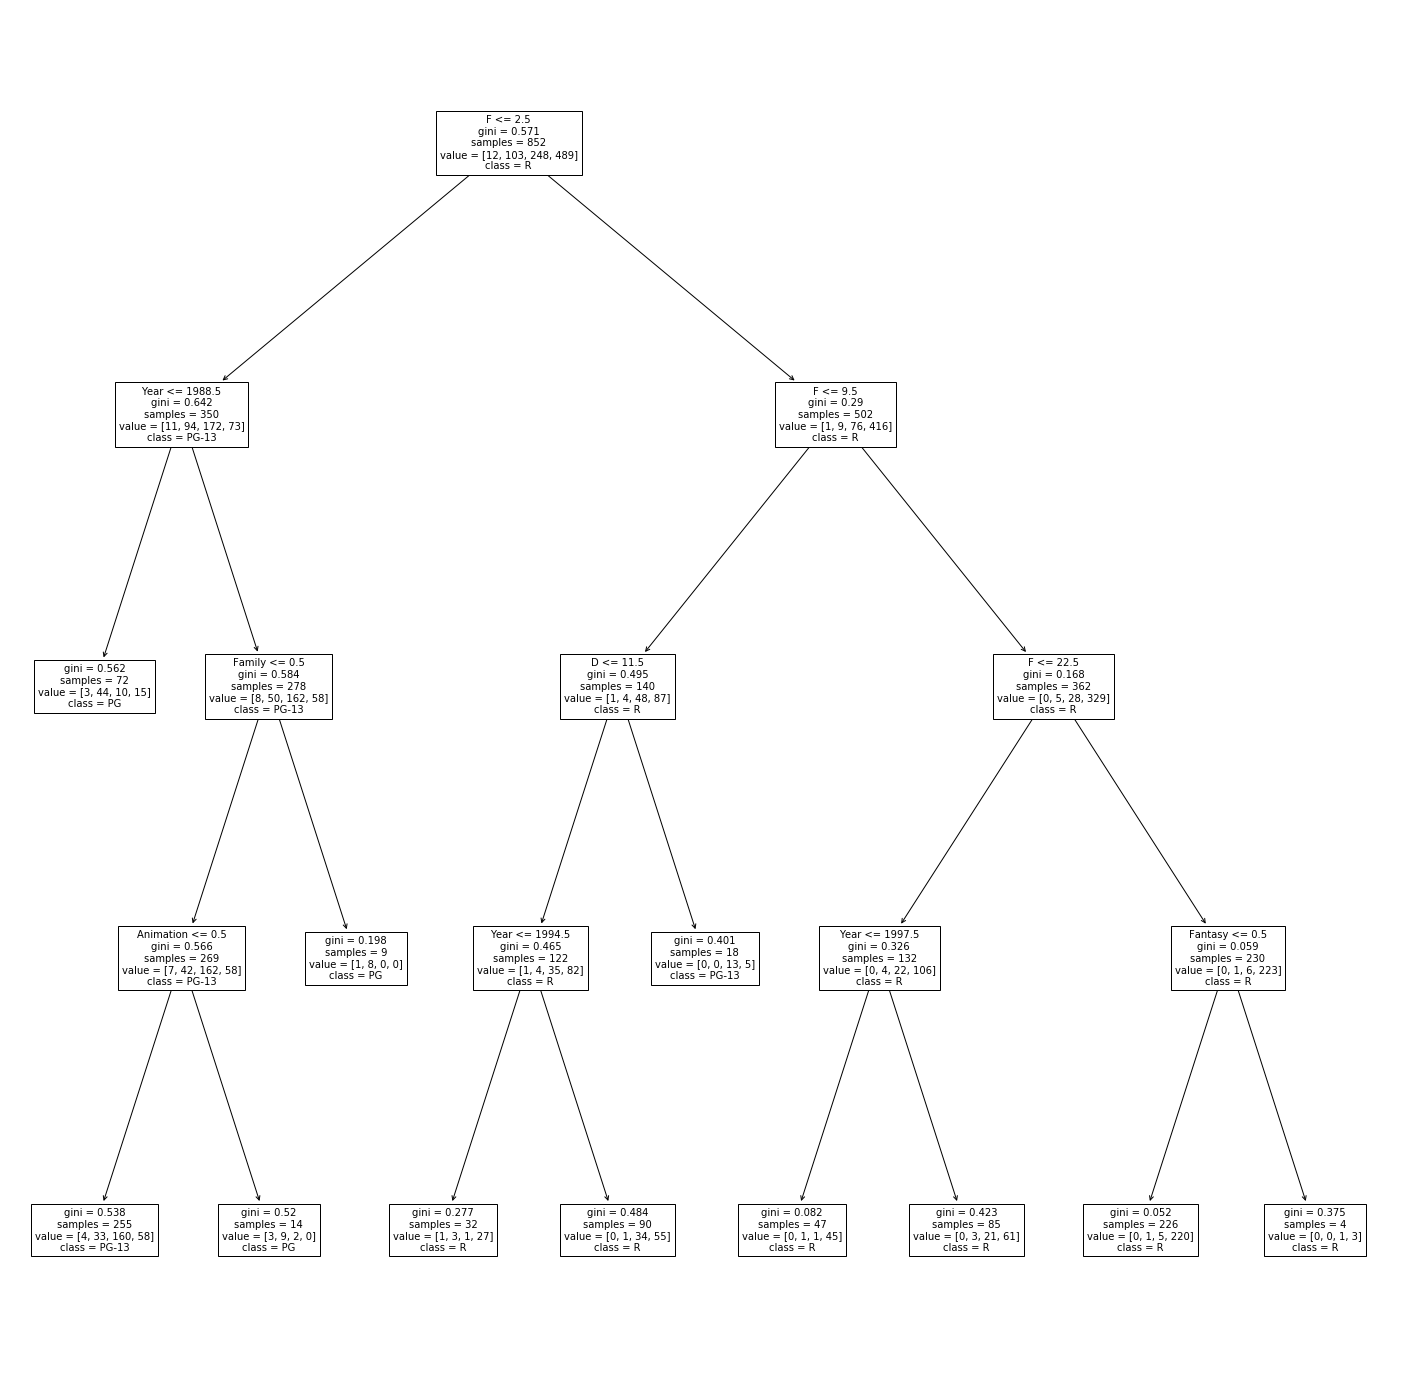

And while the logic shown in this graph isn't perfect, it does offer a slightly more distinction between the "R" and "PG-13" ratings. It also shows us that the D-word, isn't as impactful as the F-word is, with atleast eighteen films have more than 11 uttered instances of it while still keeping PG-13. This as opposed to the prevalence of the F-word, where after 10 instances, the categorization is strictly "R". 

The final thing I did seeing the effectiveness of a regular decision tree is to try a random forest: which gave better results but is unfortunately not able to give us a specific tree. 

| Features                                       | Accuracy |
|------------------------------------------------|----------|
| ['A','B','D','F','S']                          | 63.5%    |
| ['APM','BPM','DPM','FPM','SPM']                | 64.8%    |
| ['Year','A','B','D','F','S']                   | 68.0%    |
| ['Year','APM','BPM','DPM','FPM','SPM']         | 68.8%    |
| ['APM','BPM','DPM','FPM','SPM','Genre']        | 70.1%    |
| ['A','B','D','F','S','Genre']                  | 74.1%    |
| ['APM','BPM','DPM','FPM','SPM','Genre','Year'] | 77.4%    |
| ['A','B','D','F','S','Genre','Year']           | 77.4%    |

<h5>Profanity's effect on Acclaim and Revenue</h5>

The first thing I wanted to do after calculating the highest of the scaled Metascore and imdb Rating. was visualize the  distribution of what I'm looking at. 

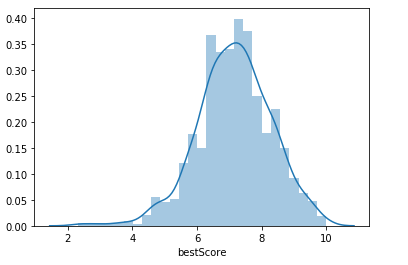



The next thing I wanted to explore was using PCA on the swear counts and rates, seeing as those were the only values that were purely numeric, and the ineffectiveness of Naive Bayes in the previous runs implied dependence in predictors. But when I plotted out the explained variance by the 5 PC's that resulted: 

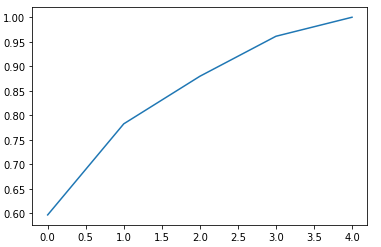

I saw that to get 95% variance explained, I'd have to use 4 PC's. Which at that point, I might as well just use all 5 original features. 

Now that we are looking at Critical Reception and Box Office as response variables, we can also include 'Rating' to the list of features that we've used before. But like 'Genre', must be dummied to be properly used. 

For both these last responses I used Linear Regression while looping through a list of feature sets and using mean squared error to find the best one. 

In the end the optimal model for Critic Score is:

| Intercept | G        | Not Rated  | PG        | PG-13     | R          | Action    | Adventure  | Animation  | Comedy    | Crime    | Drama    | Family    | Fantasy   | Film-Noir |
|-----------|----------|------------|-----------|-----------|------------|-----------|------------|------------|-----------|----------|----------|-----------|-----------|-----------|
| 40.69     | 0.37 | -0.18  | 0.045 | -0.19 | -0.033 | -0.10 | 0.035  | 0.13   | -0.37 | -0.19 | 0.32 | -0.52 | 0.019 | 1.05   |

| Horror    | Musical  | Mystery   | Romance     | Sci-Fi    | Thriller  | War      | Western    | APM      | BPM      | DPM       | FPM      | SPM       | Year      |
|-----------|----------|-----------|-------------|-----------|-----------|----------|------------|----------|----------|-----------|----------|-----------|-----------|
| -0.74 | 0.44 | -0.18 | -0.0010 | -0.15 | -0.17 | 0.55 | -0.097 | -2.047 | -1.31 | 0.045 | 0.54 | -0.55 | -0.0166 |



This model definitely should be taken with a grain of salt as the starting value for the score seems to be 40 (out of 10), which is then continually deducted from depending on your rating and genre choice and year to get a baseline score. That score can then either increase based on the number of F-word and D-words in your script, or decrease based on the number of A-words, B-words or S-words. 


Using the same approach for Box Office Revenue we get the model:

| G    | Not Rated  | PG   | PG-13  | R     | Action  | Adventure  | Animation  | Comedy  | Crime  | Drama  | Family  | Fantasy  | Horror |
|------|------------|------|--------|-------|---------|------------|------------|---------|--------|--------|---------|----------|--------|
| 47.6 | -65.0      | 14.5 | 24.6   | -21.7 | 4.8     | 36.5       | 91.3       | -38.4   | -28.6  | -41.3  | 41.8    | 12.2     | -28.0  |

| Intercept | Musical  | Mystery  | Romance  | Sci-Fi  | Thriller  | War  | Western  | A   | B    | D    | F    | S   |
|-----------|----------|----------|----------|---------|-----------|------|----------|-----|------|------|------|-----|
| 79.9      | -35.2    | -1.4     | -36.7    | 21.4    | -11.7     | -7.8 | 21.2     | 1.4 | -0.3 | -1.1 | -0.1 | 0.7 |

In Millions - this model tells us that starting with around 80 Million as your baseline domestic box office revenue. Having a PG-13 rating or milder gives your movie more widespread appeal and increases your revenue. There does not seem to be any rhyme or reason why this model ascribes some genre's to be box office poison. But once that number is set. You'll lose up to 1.1 Million dollars for every D-word in the script but gain 1.4 million dollars for every permutation of the A-word. 

Obviously, these conclusions between the relationship between profanity and Box Office Revenue and Critical Reception are completely ludicrous. Very likely - there are tons of other predictors that are missing from these two calculations that cannot be even marginally captured by simply having the number of counts of each swear word in a script. 

<h3>Final Results</h3> 

To conclude - while we were able to find how many F-words it takes to be unsalvageably rated as R, we were not able to reasonably determine the direct cause of a swear word on critic score or domestic Box office revenue. This make sense, the amount of profanity a movie has directly flavors its content, and that flavoring might make it too spicy for some audiences. The tree model (however still inaccurate) helps us identify profanity breakpoints where PG-13 becomes R, and does a reasonable job predicting ratings. Box office revenue, on the other hand is a less direct response for our chosen predictors, and is more likely to be influenced by factors not present in the data set such as number of high-profile competing films or current economic cycle. And even though the quality of a screenplay is definitely taken into consideration by critics when evaluating a movie's quality, modern films predominantly use sight and sound as mediums to tell story. Both of which fall outside the purview of the data that we have collected.  

It seems that Patrick Star was correct to a certain extent. Profanity definitely adds 'flavor' to a sentence or script. Flavor that might be deemed too spicy for certain audiences. But that spiciness isn't so much so that it is capable of influencing millions of dollars or sway entire hordes of critics. Perhaps it is a good thing to know that there is a limit on much disproportionate influence the Pareto Principal can have.